In [10]:
import sys
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load the data

train = pd.read_csv("gdrive/MyDrive/fashionMNISTdata/train.csv")
test = pd.read_csv("gdrive/MyDrive/fashionMNISTdata/test.csv")

X_train = train.drop(["index","label"],axis=1)
Y_train = train['label']

test_index = test['index']
test = test.drop(['index'], 1)

In [4]:
#pandas로 불러온 데이터는 reshape함수를 통해 28 * 28배열로 변환 시켜 준다.
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

10개의 class로 나눠져 있으며 각 번호에 대한 정보는 다음과 같다.

0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot

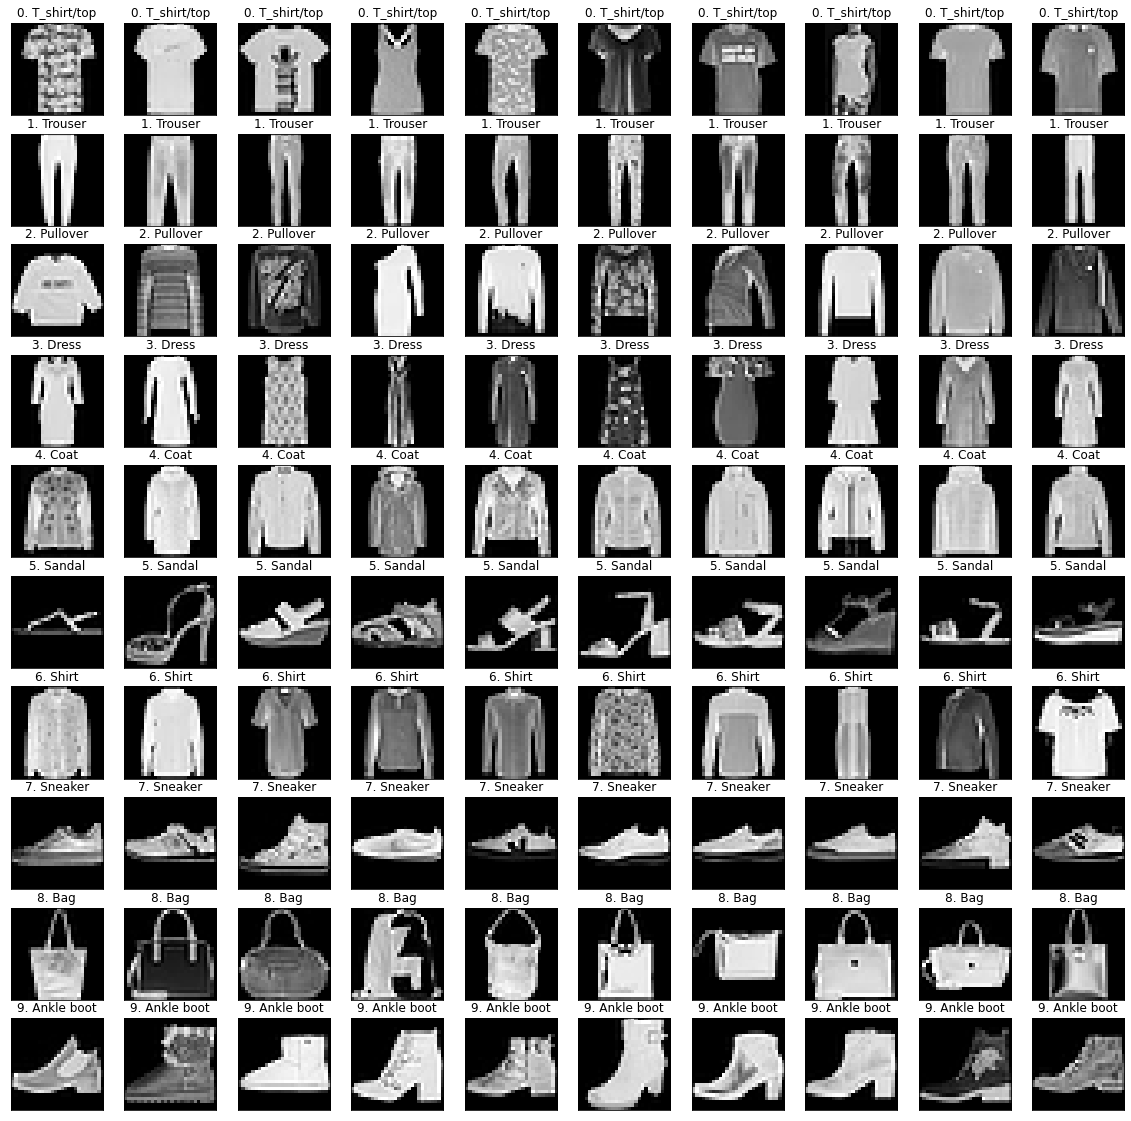

In [5]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(20, 20))
for k in range(10):
  XX = X_train[Y_train == k]
  YY = Y_train[Y_train == k].reset_index()['label']

  for i in range(10):
    plt.subplot(10, 10, k*10 + i + 1)
    plt.xticks([]) #눈금표시
    plt.yticks([])
    plt.grid(False)
    plt.imshow(XX[i][:,:,0], cmap='gray')
    label_index = int(YY[i])
    plt.title('{}. {}'.format(k, class_names[label_index]))
plt.show()

Train/test set 분류

sklearn의 model_selection에서 train_test_split 함수를 불러온 후, train set과 validation set으로 분리 시켜주자. train/val의 비율은 8:2로 test_size옵션에서 0.2를 사용 해주었다. 추가로 randaom_state=100으로 해주어, seed를 100으로 지정 해주었다.

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, 
                                                  Y_train, 
                                                  test_size = 0.2, 
                                                  random_state=100)

In [7]:
print("Train set 이미지 수: {} 개".format(X_train.shape[0]))
print("Validation set 이미지 수: {} 개".format(X_val.shape[0]))

Train set 이미지 수: 48000 개
Validation set 이미지 수: 12000 개


전처리

X:

이제 이 데이터를 255로 나누어 주자. 0에서 255의 숫자의 배열로 이루어진 이미지 데이터를 255로 나누어 주어 0~1로 변환 사켜주는 작업이다. 케라스는 데이터를 0에서 1 사이의 값으로 변환한 다음 구동할 때 최적의 성능을 보이기 때문이다. 따라서 astype()함수를 통해 실수형으로 바꿔준 후 255로 나누는 작업을 진행 했다.

Y:

Y의 경우에는 원-핫 인코딩을 적용해주자. np_utils.to_categorical()함수를 사용한다. 활성화 함수를 사용하기 위해서는 Y값이 0과 1로 이루어져야 하기 때문인데 이는 5라는 라벨을 갖고 있는 데이터를 array([0.,0.,0.,0.,1.,0.,0.,0.,0.]) 로 바꿔준다.

In [8]:
# CNN
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1).astype('float32') / 255

Y_train = np_utils.to_categorical(Y_train) #원핫인코딩 해주는 함수
Y_val = np_utils.to_categorical(Y_val)

In [39]:
# 컨볼루션 신경망 설정
model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), input_shape=(28,28,1), activation='relu'))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128,activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(10, activation='softmax'))

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 5, 32)         

모델 컴파일

모델을 컴파일 해보자. 오차 함수로cetegorical_crossentropy, 최적화 함수로 adam을 사용한다.

In [40]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

모델 최적화 설정

이제 모델의 성과를 저장하고 모델의 최적화 단계에서 학습을 중단하게끔 설정 해주자. 이는 10회 이상 모델의 성과 향상이 없으면 자동으로 학습을 중단하게 된다.

In [41]:
MODEL_DIR = "./model/"

if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor = 'val_loss', verbose=1, save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


이렇게 샘플 200개를 모두 30회 실행하게 해주았다. 그리고 valid set으로 최종 모델의 성과를 측정하여 그 값을 출력하게 해주었다. 이때, 조금 주의해야 할것이 있다면 cpu로 돌리는데 시간이 매우 많이 걸리기 때문에, gpu를 사용해주도록 한다.

In [42]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), 
                    epochs=50, 
                    batch_size=200, 
                    verbose=0, 
                    callbacks=[early_stopping_callback, checkpointer])

print("\n Test Accuracy: %.4f" % (model.evaluate(X_val, Y_val)[1]))


Epoch 00001: val_loss improved from inf to 0.65805, saving model to ./model/01-0.6580.hdf5

Epoch 00002: val_loss improved from 0.65805 to 0.55246, saving model to ./model/02-0.5525.hdf5

Epoch 00003: val_loss improved from 0.55246 to 0.50693, saving model to ./model/03-0.5069.hdf5

Epoch 00004: val_loss improved from 0.50693 to 0.45605, saving model to ./model/04-0.4560.hdf5

Epoch 00005: val_loss improved from 0.45605 to 0.41858, saving model to ./model/05-0.4186.hdf5

Epoch 00006: val_loss improved from 0.41858 to 0.39202, saving model to ./model/06-0.3920.hdf5

Epoch 00007: val_loss improved from 0.39202 to 0.36679, saving model to ./model/07-0.3668.hdf5

Epoch 00008: val_loss improved from 0.36679 to 0.35271, saving model to ./model/08-0.3527.hdf5

Epoch 00009: val_loss improved from 0.35271 to 0.33529, saving model to ./model/09-0.3353.hdf5

Epoch 00010: val_loss improved from 0.33529 to 0.33062, saving model to ./model/10-0.3306.hdf5

Epoch 00011: val_loss improved from 0.33062

오차와 정확도 확인

실행 결과를 그래프로 확인해보자. 오차와 정확도를 확인하려 한다.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
# 오차
y_vloss = history.history['val_loss']
# 학습셋 오차
y_loss = history.history['loss']
# 그래프로 표현
x_len = np.arange(len(y_loss))
ax1.plot(x_len, y_vloss, marker = '.', c="red", label='Testset_loss')
ax1.plot(x_len, y_loss, marker = '.', c='blue', label = 'Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
ax1.legend(loc='upper right')
ax1.grid()
ax1.set(xlabel='epoch', ylabel='loss')

# 정확도
y_vaccuracy = history.history['val_accuracy']

# 학습셋
y_accuracy = history.history['accuracy']

# 그래프로 표현
x_len = np.arange(len(y_accuracy))
ax2.plot(x_len, y_vaccuracy, marker = '.', c="red", label='Testset_accuracy')
ax2.plot(x_len, y_accuracy, marker = '.', c='blue', label = 'Trainset_accuracy')

# 그래프에 그리드를 주고 레이블을 표시
ax2.legend(loc='lower right')
ax2.grid()

ax2.set(xlabel='epoch', ylabel='accuracy')

# draw gridlines
ax2.grid(True)
plt.show()

틀린 데이터 확인

분류를 하는데 어떤 것을 틀렸는지 확인해보자.

In [ ]:
y_pred = model.predict(X_val).round(2)

y_val_label = list(map(np.argmax, Y_val)) # 테스트셋 라벨(정답)
y_pred_label = list(map(np.argmax, y_pred)) # 예측 라벨 


In [ ]:
plt.figure(figsize = (16,9))

cm = confusion_matrix(y_val_label,y_pred_label)

sns.heatmap(cm , annot = True,fmt = 'd',xticklabels = class_names,yticklabels = class_names)

In [ ]:
#예측값과 정답이 다른경우 aaa = true
aaa = np.array(y_val_label) != np.array(y_pred_label)

not_equel_list = np.where(aaa == True)[0]

plt.figure(figsize=(20,20))
j = 1
for i in not_equel_list[0:36]:
# for a in np.random.randint(0,206,36):
#     i = not_equel_list[a]
#     print(a)
    plt.subplot(6,6,j); j+=1
    plt.imshow(X_val[i].reshape(28,28),cmap = 'Greys')
    plt.axis('off')
    plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_names[y_val_label[i]],
                                                            y_val_label[i],
                                                            class_names[y_pred_label[i]],
                                                            y_pred_label[i]))

In [ ]:
results = model.predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("results_fashion_mnist.csv",index=False)